In [1]:
import re
import os
import wandb
import string
import numpy as np
import unicodedata
import pandas as pd
from pathlib import Path
from datasets import load_dataset
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import flash_attn
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import EarlyStoppingCallback
from transformers import AutoTokenizer, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import sys
sys.path.append('../../../')

Check versions of important packages

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Flash Attention version:", flash_attn.__version__)

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
Flash Attention version: 2.7.4.post1


Check which python we are using

In [3]:
print(sys.executable)

/share/miniforge3/bin/python3.10


REMOVE BEFORE PUSHING OR MAKING PUBLIC IN ANY FORM !!!

In [4]:
hg_token = ""

In [5]:
dataset_names = ['covidqa', 'cuad', 'delucionqa', 'emanual', 'expertqa', 'finqa', 'hagrid', 'hotpotqa', 'msmarco', 'pubmedqa', 'tatqa', 'techqa']

# load pubmedqa from RAGBENCH
pubmedqa = load_dataset("rungalileo/ragbench", "pubmedqa")

In [6]:
train_data_raw = pubmedqa['train'].to_pandas()
test_data_raw = pubmedqa['test'].to_pandas()

# Exploration

In [7]:
train_data_raw.head()

,id,question,documents,response,generation_model_name,annotating_model_name,dataset_name,documents_sentences,response_sentences,sentence_support_information,...,trulens_groundedness,trulens_context_relevance,ragas_faithfulness,ragas_context_relevance,gpt3_adherence,gpt3_context_relevance,gpt35_utilization,relevance_score,utilization_score,completeness_score
0,pubmedqa_39085,Is there a functional neural correlate of indi...,[The present study tested whether individuals ...,"Yes, the study mentioned in the first piece of...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, The present study tested whether indivi...","[[a, Yes, the study mentioned in the first pie...",[{'explanation': 'This sentence is directly su...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,0.142857,1.000000
1,pubmedqa_42813,Can we use the Omron T9P automated blood press...,"[Recent events in our hospital, combined with ...","Yes, based on the context provided, we can use...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, Recent events in our hospital, combined...","[[a, Yes, based on the context provided, we ca...",[{'explanation': 'This sentence summarizes the...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454545,0.181818,0.400000
2,pubmedqa_57525,Intraabdominal vascular injury: are we getting...,[Intraabdominal vascular injury (IAVI) as a re...,"Based on the pieces of context provided, the s...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, Intraabdominal vascular injury (IAVI) a...","[[a, Based on the pieces of context provided, ...",[{'explanation': 'This sentence is partially s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.461538,0.307692,0.666667
3,pubmedqa_29863,Hand grip and pinch strength in patients with ...,[The hand grip strength test and pinch was sig...,"Yes, according to the context provided, the ha...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, The hand grip strength test and pinch w...","[[a, Yes, according to the context provided, t...",[{'explanation': 'This sentence is supported b...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.818182,0.181818,0.222222
4,pubmedqa_36126,Is Canada ready for patient accessible electro...,[Access to personal health information through...,"Based on the information provided, Canada is n...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, Access to personal health information t...","[[a, Based on the information provided, Canada...",[{'explanation': 'The sentence is supported by...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636364,0.454545,0.714286


In [8]:
train_data_raw.shape

(19600, 26)

In [9]:
train_data_raw.columns

Index(['id', 'question', 'documents', 'response', 'generation_model_name',
       'annotating_model_name', 'dataset_name', 'documents_sentences',
       'response_sentences', 'sentence_support_information',
       'unsupported_response_sentence_keys', 'adherence_score',
       'overall_supported_explanation', 'relevance_explanation',
       'all_relevant_sentence_keys', 'all_utilized_sentence_keys',
       'trulens_groundedness', 'trulens_context_relevance',
       'ragas_faithfulness', 'ragas_context_relevance', 'gpt3_adherence',
       'gpt3_context_relevance', 'gpt35_utilization', 'relevance_score',
       'utilization_score', 'completeness_score'],
      dtype='object')

In [10]:
observation = train_data_raw.iloc[0]

In [11]:
observation.question

'Is there a functional neural correlate of individual differences in cardiovascular reactivity?'

In [12]:
train_data_raw.all_relevant_sentence_keys

0                                        [0a]
1                        [0a, 1a, 3a, 3b, 4a]
2                    [0a, 0b, 2a, 3c, 3e, 4a]
3        [0a, 0b, 1a, 2a, 2b, 2c, 2d, 2e, 2f]
4                [0a, 0b, 0c, 0d, 1a, 1b, 1c]
                         ...                 
19595        [0a, 0b, 1a, 1b, 2a, 2c, 2d, 3a]
19596                    [0a, 0b, 0c, 0d, 1b]
19597                [0a, 1a, 2a, 3a, 3d, 4c]
19598        [0b, 0c, 0d, 0e, 1a, 1b, 1c, 1d]
19599                [0b, 1a, 1b, 1c, 4a, 4f]
Name: all_relevant_sentence_keys, Length: 19600, dtype: object

# Attributes

In [13]:
relevant_cols = ["question", "documents_sentences", "all_relevant_sentence_keys"]

**Columns**:

- **question:** The medical question being asked. (Used as input)
- **documents_sentences:** Contains the sentences from the source documents. (Context for classification)
- **all_relevant_sentence_keys:**	Identifies which sentences are relevant. (Binary label for classification)

**Goal:**

- Pair each question with its individual document sentences → (question, sentence) pairs.
- Label each sentence as relevant (1) or not relevant (0) → Using all_relevant_sentence_keys.
- Train a classifier using BERT embeddings to classify each sentence.


In [14]:
train_data = train_data_raw[relevant_cols]
test_data = test_data_raw[relevant_cols]

In [15]:
train_data.head()

,question,documents_sentences,all_relevant_sentence_keys
0,Is there a functional neural correlate of indi...,"[[[0a, The present study tested whether indivi...",[0a]
1,Can we use the Omron T9P automated blood press...,"[[[0a, Recent events in our hospital, combined...","[0a, 1a, 3a, 3b, 4a]"
2,Intraabdominal vascular injury: are we getting...,"[[[0a, Intraabdominal vascular injury (IAVI) a...","[0a, 0b, 2a, 3c, 3e, 4a]"
3,Hand grip and pinch strength in patients with ...,"[[[0a, The hand grip strength test and pinch w...","[0a, 0b, 1a, 2a, 2b, 2c, 2d, 2e, 2f]"
4,Is Canada ready for patient accessible electro...,"[[[0a, Access to personal health information t...","[0a, 0b, 0c, 0d, 1a, 1b, 1c]"


In [16]:
print(f"Number of rows: {len(train_data)}")

Number of rows: 19600


# Attribute Transformation

In [17]:
import ast

In [18]:
def safe_eval(val):
    if isinstance(val, str):  # If it's a string, evaluate it
        return ast.literal_eval(val)
    elif isinstance(val, list) or isinstance(val, tuple):  # If already a list, return as is
        return list(val)
    else:
        return []  # Default case, return empty list

In [19]:
train_data = train_data.copy()
train_data.loc[:, "documents_sentences"] = train_data["documents_sentences"]\
    .apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

test_data = test_data.copy()
test_data.loc[:, "documents_sentences"] = test_data["documents_sentences"]\
    .apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [20]:
def transform_dataset(train_data):
    """
    Transforms the dataset into a list of (question, sentence, label) tuples.

    Args:
        train_data (pd.DataFrame): DataFrame containing 'question', 'all_relevant_sentence_keys', and 'documents_sentences'.

    Returns:
        list: A list of tuples (question, sentence_text, label).
    """
    data_rows = []

    for _, row in train_data.iterrows():
        question = row["question"]
        relevant_keys = set(row["all_relevant_sentence_keys"])  # Convert to set for quick lookup

        for doc_sentences in row["documents_sentences"]:
            for sentence in doc_sentences:  # sentence is a list like [key, text]
                if len(sentence) == 2:  # Ensure correct format
                    sentence_key, sentence_text = sentence
                    label = 1 if sentence_key in relevant_keys else 0  # Assign label
                    data_rows.append((question, sentence_text, label))

    return data_rows

In [21]:
train_data = pd.DataFrame(transform_dataset(train_data), columns=["question", "sentence", "label"])
test_data = pd.DataFrame(transform_dataset(test_data), columns=["question", "sentence", "label"])

In [22]:
print(f"Number of rows: {len(train_data)}")

Number of rows: 237544


**Check Class Imbalance**

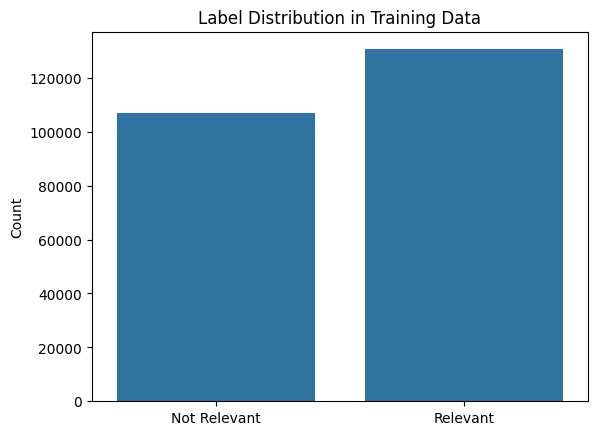

Label counts:
 label
0    106989
1    130555
Name: count, dtype: int64


In [23]:
label_counts = train_data["label"].value_counts().sort_index()
label_names = ["Not Relevant", "Relevant"]

# Plot
sns.barplot(x=label_names, y=label_counts.values)
plt.title("Label Distribution in Training Data")
plt.ylabel("Count")
plt.show()

print("Label counts:\n", label_counts)

# Preprocessing

In [24]:
train_data.dtypes

question    object
sentence    object
label        int64
dtype: object

Ensure we are working with strings

In [25]:
train_data["question"] = train_data["question"].astype(str)
train_data["sentence"] = train_data["sentence"].astype(str)
test_data["question"] = test_data["question"].astype(str)
test_data["sentence"] = test_data["sentence"].astype(str)

Check for missing values

In [26]:
print(train_data.isnull().sum())

question    0
sentence    0
label       0
dtype: int64


**Note:** We might want to check for duplicates here

Convert strings to lowercase

In [27]:
train_data["question"] = train_data["question"].str.lower()
train_data["sentence"] = train_data["sentence"].str.lower()
test_data["question"] = test_data["question"].str.lower()
test_data["sentence"] = test_data["sentence"].str.lower()

Remove Extra Whitespaces & Newlines

In [28]:
def clean_whitespace(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
    return text.strip()

In [29]:
train_data["question"] = train_data["question"].apply(clean_whitespace)
train_data["sentence"] = train_data["sentence"].apply(clean_whitespace)
test_data["question"] = test_data["question"].apply(clean_whitespace)
test_data["sentence"] = test_data["sentence"].apply(clean_whitespace)

Normalize Unicode Characters

In [30]:
def normalize_unicode(text):
    return unicodedata.normalize("NFKC", text)

In [31]:
train_data["question"] = train_data["question"].apply(normalize_unicode)
train_data["sentence"] = train_data["sentence"].apply(normalize_unicode)
test_data["question"] = test_data["question"].apply(normalize_unicode)
test_data["sentence"] = test_data["sentence"].apply(normalize_unicode)

Remove Punctuation

In [32]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [33]:
train_data["question"] = train_data["question"].apply(remove_punctuation)
train_data["sentence"] = train_data["sentence"].apply(remove_punctuation)
test_data["question"] = test_data["question"].apply(remove_punctuation)
test_data["sentence"] = test_data["sentence"].apply(remove_punctuation)

Safe if necessary

In [34]:
'''
train_data.to_csv("../../data/dev/processed/pubmedqa_train.csv", index=False)
test_data.to_csv("../../data/dev/processed/pubmedqa_test.csv", index=False)
''';

In [35]:
train_data.head()

,question,sentence,label
0,is there a functional neural correlate of indi...,the present study tested whether individuals w...,1
1,is there a functional neural correlate of indi...,this study examined whether heightened cardiov...,0
2,is there a functional neural correlate of indi...,heart rate variability hrv a measure of autono...,0
3,is there a functional neural correlate of indi...,previous studies have also not controlled for ...,0
4,is there a functional neural correlate of indi...,low socioeconomic status is associated with in...,0


Aggregate Sentences Per Question

In [36]:
aggregated_train_data = defaultdict(lambda: {"sentences": [], "labels": []})
aggregated_test_data = defaultdict(lambda: {"sentences": [], "labels": []})

for _, row in train_data.iterrows():
    q = row["question"]
    aggregated_train_data[q]["sentences"].append(row["sentence"])
    aggregated_train_data[q]["labels"].append(row["label"])

for _, row in test_data.iterrows():
    q = row["question"]
    aggregated_test_data[q]["sentences"].append(row["sentence"])
    aggregated_test_data[q]["labels"].append(row["label"])

aggregated_train_df = pd.DataFrame([
    {"question": q, "sentences": v["sentences"], "labels": v["labels"]}
    for q, v in aggregated_train_data.items()
])
aggregated_test_df = pd.DataFrame([
    {"question": q, "sentences": v["sentences"], "labels": v["labels"]}
    for q, v in aggregated_test_data.items()
])

In [37]:
aggregated_train_df.head()

,question,sentences,labels
0,is there a functional neural correlate of indi...,[the present study tested whether individuals ...,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]"
1,can we use the omron t9p automated blood press...,[recent events in our hospital combined with i...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ..."
2,intraabdominal vascular injury are we getting ...,[intraabdominal vascular injury iavi as a resu...,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, ..."
3,hand grip and pinch strength in patients with ...,[the hand grip strength test and pinch was sig...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ..."
4,is canada ready for patient accessible electro...,[access to personal health information through...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ..."


# Further Processing

We’ll create one row per sentence: full context + label for only that sentence

And add [START] and [END] markers around the target sentence

In [38]:
def expand_to_sentence_level(df, sep=". ", window=1):
    expanded = []

    for _, row in df.iterrows():
        question = row["question"]
        sentences = row["sentences"]
        labels = row["labels"]

        for i, (sentence, label) in enumerate(zip(sentences, labels)):
            # Get window range
            start = max(0, i - window)
            end = min(len(sentences), i + window + 1)

            # Clone to avoid in-place edit
            context_slice = sentences[start:end].copy()
            target_local_idx = i - start
            context_slice[target_local_idx] = f"[START] {context_slice[target_local_idx]} [END]"

            expanded.append({
                "question": question,
                "context": sep.join(context_slice),
                "target_sentence": sentence,
                "target_index": i,
                "label": label
            })

    return pd.DataFrame(expanded)


In [39]:
WINDOW_SIZE = 0

In [40]:
train_df = expand_to_sentence_level(aggregated_train_df, window=WINDOW_SIZE)
test_df = expand_to_sentence_level(aggregated_test_df, window=WINDOW_SIZE)

In [41]:
train_df.head()

,question,context,target_sentence,target_index,label
0,is there a functional neural correlate of indi...,[START] the present study tested whether indiv...,the present study tested whether individuals w...,0,1
1,is there a functional neural correlate of indi...,[START] this study examined whether heightened...,this study examined whether heightened cardiov...,1,0
2,is there a functional neural correlate of indi...,[START] heart rate variability hrv a measure o...,heart rate variability hrv a measure of autono...,2,0
3,is there a functional neural correlate of indi...,[START] previous studies have also not control...,previous studies have also not controlled for ...,3,0
4,is there a functional neural correlate of indi...,[START] low socioeconomic status is associated...,low socioeconomic status is associated with in...,4,0


# Training End-To-End

Important Configs

In [42]:
CONTEXT_LENGTH = 512
BATCH_SIZE = 64

In [43]:
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", token=hg_token)
special_tokens = {"additional_special_tokens": ["[START]", "[END]"]}
tokenizer.add_special_tokens(special_tokens);

Load ModernBERT Model (Trainable Embeddings)

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(
    "answerdotai/ModernBERT-base", num_labels=2, token=hg_token, attn_implementation="flash_attention_2"
)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
# Resize model embeddings to match new special tokens
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50370, 768, padding_idx=50283)

Check if model parameters are trainable (Ensure We Are Training End-to-End)

In [46]:
for param in model.parameters():
    param.requires_grad = True  # Ensure the entire model is updated

Prepare the dataset

In [47]:
dataset_train = Dataset.from_pandas(train_df)
dataset_test = Dataset.from_pandas(test_df)

In [48]:
progress_bar = tqdm(total=((len(dataset_train)+len(dataset_test))),
                    desc="Tokenizing", position=0, leave=True)

Tokenizing:   0%|          | 0/267410 [00:00<?, ?it/s]

In [49]:
def tokenize_batch(batch):
    encodings = tokenizer(
        batch["question"],
        batch["context"],
        padding="max_length",
        truncation=True,
        max_length=CONTEXT_LENGTH,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"].tolist(),
        "attention_mask": encodings["attention_mask"].tolist(),
        "labels": batch["label"]
    }

def tokenize_with_progress(batch):
    out = tokenize_batch(batch)
    progress_bar.update(len(batch["question"]))
    return out

In [50]:
tokenized_dataset_train = dataset_train.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)
tokenized_dataset_test = dataset_test.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)

Parameter 'function'=<function tokenize_with_progress at 0x149d11443e20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/237544 [00:00<?, ? examples/s]

Map:   0%|          | 0/29866 [00:00<?, ? examples/s]

In [51]:
progress_bar.close()

Convert to PyTorch Dataset (Ensure dataset is set to PyTorch format)

In [52]:
tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Create DataLoader for Batching

In [53]:
train_dataloader = DataLoader(tokenized_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(tokenized_dataset_test, batch_size=BATCH_SIZE)

# Check one batch
batch = next(iter(train_dataloader))
print({key: value.shape for key, value in batch.items()})

{'input_ids': torch.Size([64, 512]), 'attention_mask': torch.Size([64, 512]), 'labels': torch.Size([64])}


Quick check if everything is correct before training

In [54]:
print("----- Training Set -----")
print(tokenized_dataset_train)
print(tokenized_dataset_train.column_names)
print("----- Test Set -----")
print(tokenized_dataset_test)
print(tokenized_dataset_test.column_names)

----- Training Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 237544
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']
----- Test Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 29866
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']


In [55]:
output_dir = Path("../../checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

# Training Configurations

Define training arguments & initialize trainer

In [56]:
NUM_EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 5e-5
DATASET_NAME = "pubmedqa"

WANDB_PROJECT_NAME = "RAGBENCH-PUBMED"
WANDB_RUN_NAME = f"Train-Improved-WindowSize:{WINDOW_SIZE}-03"
WANDB_NOTEBOOK_NAME = "train_sc_on_pubmed"

Setup W&B

In [57]:
os.environ["WANDB_NOTEBOOK_NAME"] = "train_sc_on_pubmed.ipynb"
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: flackojodye (asap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [58]:
config = dict(
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    dataset=DATASET_NAME,
    architecture="MODERN-BERT",
    window_size=WINDOW_SIZE,
    early_stopping=True,
    eval_steps=500,
    label_smoothing_factor=0.0,
    gradient_clipping=1.0,
    load_best_model=True,
    metric_for_best_model="f1",
    input_format="question + context with [START]/[END]"
)


Generate run-id to resume same run after training 

In [59]:
run_id = wandb.util.generate_id()

In [60]:
wandb.init(
    project=WANDB_PROJECT_NAME,
    name=WANDB_RUN_NAME,
    config=config,
    id=run_id,
    resume="allow"               # resume if it exists, else start new
)

In [61]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }

In [62]:
training_args = TrainingArguments(
    output_dir=output_dir,                        # Where model checkpoints will be saved
    run_name=WANDB_RUN_NAME,                      # Name for W&B tracking
    learning_rate=LEARNING_RATE,                  # Base learning rate
    per_device_train_batch_size=BATCH_SIZE,       # Training batch size
    per_device_eval_batch_size=(2 * BATCH_SIZE),  # Larger eval batch size to speed up
    num_train_epochs=NUM_EPOCHS,                  # Total training epochs
    weight_decay=0.01,                            # L2 regularization
    
    # Evaluation and saving settings
    evaluation_strategy="steps",                  # Evaluate every N steps
    eval_steps=500,                               # Eval frequency
    save_strategy="steps",                        # Save checkpoints every N steps
    save_steps=500,
    
    # Logging
    logging_dir="./logs",                         # Log folder
    logging_strategy="steps",
    logging_steps=250,
    report_to="wandb",                            # Log to Weights & Biases

    # Smart checkpointing
    load_best_model_at_end=True,                  # Load the best model after training
    metric_for_best_model="f1",                   # Focus on F1 (False positives and false negatives both matter)
    greater_is_better=True,                       # Higher F1 is better

    # Optimization tweaks
    gradient_accumulation_steps=1,                # For effective batch size
    label_smoothing_factor=0.0,                   # Helps generalization for classification
    fp16=True,                                    # Mixed precision for faster training (if supported)
    gradient_checkpointing=True,                  # Reduce memory usage during training
    max_grad_norm=1.0                             # Clip gradients to avoid instability
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)] # Prevent overfitting by stopping when eval loss stops improving
)


model = AutoModelForSequenceClassification.from_pretrained(
    "answerdotai/ModernBERT-base", num_labels=2, token=hg_token, attn_implementation="flash_attention_2"
)

/home/paul.schmitt/.local/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Make sure we are using the GPU

In [63]:
print("GPU Available:", torch.cuda.is_available())  
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: True
GPU Name: NVIDIA A40


In [64]:
model.to("cuda");

In [65]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.687000,0.696534,0.477566,0.569608,0.429029,0.847214
1000,0.675800,0.706886,0.489486,0.574403,0.435274,0.844260
1500,0.646600,0.647403,0.624657,0.543455,0.539500,0.547469
2000,0.619100,0.645990,0.637548,0.583349,0.549369,0.621810
2500,0.599700,0.687109,0.625561,0.610715,0.530351,0.719783
3000,0.583400,0.665958,0.633262,0.617015,0.537594,0.723968
3500,0.573300,0.640495,0.638418,0.615434,0.543664,0.709034
4000,0.514600,0.695179,0.619701,0.619599,0.523457,0.759005
4500,0.513400,0.748803,0.619233,0.622067,0.522762,0.767949
5000,0.492400,0.714757,0.627670,0.618499,0.531455,0.739641


TrainOutput(global_step=8500, training_loss=0.5313046587775735, metrics={'train_runtime': 1129.6541, 'train_samples_per_second': 630.841, 'train_steps_per_second': 9.858, 'total_flos': 1.8535591185609523e+17, 'train_loss': 0.5313046587775735, 'epoch': 2.2898706896551726})

Save the model (optional)

In [66]:
models_dir = Path("../../models/")
models_dir.mkdir(parents=True, exist_ok=True)

In [67]:
model.save_pretrained(models_dir)
tokenizer.save_pretrained(models_dir)

('../../models/tokenizer_config.json',
 '../../models/special_tokens_map.json',
 '../../models/tokenizer.json')

**Check Results**

Initialize this one more time because wandb closes automatically after training

In [68]:
run = wandb.init(
    project=WANDB_PROJECT_NAME,
    id=run_id,
    resume="must"  # must resume, or error if run doesn't exist
)

eval/accuracy,▁▂▇█▇██▇▇▇██▇▇█▇█
eval/f1,▃▄▁▄▇▇▇▇█▇████▇▇▇
eval/loss,▃▃▁▁▃▂▁▃▅▃▃▃▄▃▇█▆
eval/precision,▁▁▇█▇▇█▆▆▇▇█▇▇▇▇█
eval/recall,██▁▃▅▅▅▆▆▅▆▅▆▆▅▅▅
eval/runtime,▁▆▃▅▃▄▃▄▄▃▅▅▄▄█▇█
eval/samples_per_second,█▃▆▄▆▅▆▅▅▆▄▄▅▅▁▂▁
eval/steps_per_second,█▃▆▄▆▅▆▅▅▆▄▄▅▅▁▂▁
train/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁▁▃▁▃▂▃▃▃▃▂▄▃▂▆▄▅▄▄▄▅▅▆▅▄▅▄▇▅█▇█▆▇


In [69]:
results = trainer.evaluate()
df_results = pd.DataFrame([results])

In [70]:
label_names = ["Not Relevant", "Essential"]

## Main Model

Load model & tokenizer

In [71]:
'''
model = AutoModelForSequenceClassification.from_pretrained(models_dir)
# tokenizer = AutoTokenizer.from_pretrained(models_dir)
''';

Define training arguments

In [72]:
'''
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=(2 * BATCH_SIZE),
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    fp16=True,                            
    gradient_accumulation_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
)
''';

**Results**

In [73]:
df_results

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.732227,0.622949,0.625843,0.525851,0.772791,9.8062,3045.628,23.862,2.289871


**Classification Report**

In [74]:
predictions = trainer.predict(tokenized_dataset_test)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
report = pd.DataFrame(classification_report(labels, preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.768401,0.519656,0.620010,17679.000000
1,0.525851,0.772791,0.625843,12187.000000
accuracy,0.622949,0.622949,0.622949,0.622949
macro avg,0.647126,0.646223,0.622927,29866.000000
weighted avg,0.669427,0.622949,0.622390,29866.000000


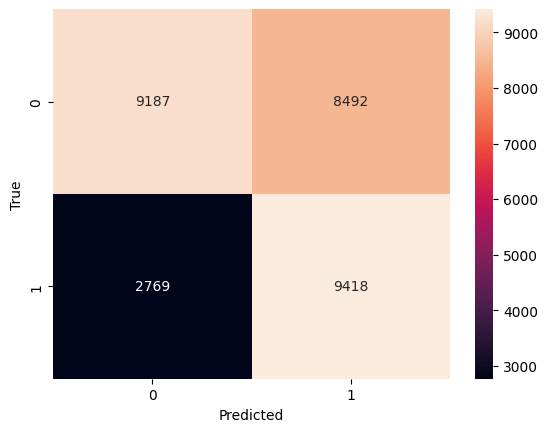

In [75]:
cm = confusion_matrix(predictions.label_ids, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Persist Results

In [76]:
eval_results_dir = f"./results/{WANDB_RUN_NAME}"
os.makedirs(eval_results_dir, exist_ok=True)

**Locally**

In [77]:
report.to_csv(os.path.join(eval_results_dir, "classification_report.csv"))

# Save Confusion Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(eval_results_dir, "confusion_matrix.png"))
plt.close()

**To Wandb**

In [78]:
metrics_to_log = {
    "eval/accuracy": report.loc["accuracy", "f1-score"],
    "eval/f1_weighted": report.loc["weighted avg", "f1-score"],
    "eval/f1_class_0": report.loc["0", "f1-score"],
    "eval/f1_class_1": report.loc["1", "f1-score"],
    "eval/recall_class_0": report.loc["0", "recall"],
    "eval/recall_class_1": report.loc["1", "recall"]
}

wandb.log(metrics_to_log)
wandb.log({
    "confusion_matrix": wandb.Image(os.path.join(eval_results_dir, "confusion_matrix.png"))
})

In [79]:
wandb.finish()

eval/accuracy,▁▁
eval/f1,▁
eval/f1_class_0,▁
eval/f1_class_1,▁
eval/f1_weighted,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/recall_class_0,▁
eval/recall_class_1,▁
eval/runtime,▁


# Baseline Model

Vectorize the sentence with TF-IDF and train a logistic regression model. Fast and interpretable + a classic ML baseline

In [80]:
train_baseline_texts = (train_data["question"] + " [SEP] " + train_data["sentence"]).tolist()
test_baseline_texts = (test_data["question"] + " [SEP] " + test_data["sentence"]).tolist()

In [81]:
train_labels = train_data["label"].tolist()
test_labels = test_data["label"].tolist()

In [82]:
from sklearn.pipeline import Pipeline

In [83]:
baseline_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [84]:
# Train baseline model

In [85]:
baseline_pipeline.fit(train_baseline_texts, train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [86]:
test_preds = baseline_pipeline.predict(test_baseline_texts)
report = pd.DataFrame(classification_report(test_labels, test_preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.661992,0.536739,0.592822,17679.000000
1,0.472702,0.602445,0.529745,12187.000000
accuracy,0.563551,0.563551,0.563551,0.563551
macro avg,0.567347,0.569592,0.561283,29866.000000
weighted avg,0.584751,0.563551,0.567083,29866.000000


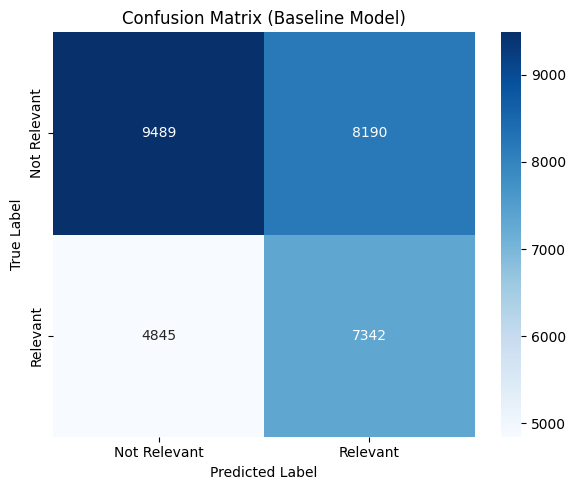

In [87]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
labels = ["Not Relevant", "Relevant"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Baseline Model)")
plt.tight_layout()
plt.show()